# Prompting on Liar Dataset

## Dataset Setup

In [1]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"]="expandable_segments:True"

In [2]:
import datasets

liar = datasets.load_dataset("liar")
liar

DatasetDict({
    train: Dataset({
        features: ['id', 'label', 'statement', 'subject', 'speaker', 'job_title', 'state_info', 'party_affiliation', 'barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts', 'context'],
        num_rows: 10269
    })
    test: Dataset({
        features: ['id', 'label', 'statement', 'subject', 'speaker', 'job_title', 'state_info', 'party_affiliation', 'barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts', 'context'],
        num_rows: 1283
    })
    validation: Dataset({
        features: ['id', 'label', 'statement', 'subject', 'speaker', 'job_title', 'state_info', 'party_affiliation', 'barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts', 'context'],
        num_rows: 1284
    })
})

In [3]:
train = liar["train"]
test = liar["test"]
val = liar["validation"]

In [4]:
full_liar = datasets.concatenate_datasets([train, test, val])
full_liar

/home/016854656/miniconda3/envs/torch/lib/python3.11/site-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by mode='default'.
  table = cls._concat_blocks(blocks, axis=0)


Dataset({
    features: ['id', 'label', 'statement', 'subject', 'speaker', 'job_title', 'state_info', 'party_affiliation', 'barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts', 'context'],
    num_rows: 12836
})

## Model Loading

In [5]:
falcon = "tiiuae/falcon-7b-instruct"
llama = "meta-llama/Llama-2-7b-chat-hf"
mistral = "mistralai/Mistral-7B-Instruct-v0.2"
orca = "microsoft/Orca-2-7b"

In [6]:
# change this depending on experiment
model_name = mistral

In [7]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoConfig
import accelerate

# config = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_compute_dtype=torch.bfloat16)
tokenizer = AutoTokenizer.from_pretrained(model_name)
config = AutoConfig.from_pretrained(
    model_name
)
with accelerate.init_empty_weights():
    model = AutoModelForCausalLM.from_config(config, torch_dtype=torch.bfloat16)

In [8]:
if model_name == falcon:
    print(model.transformer)
else:
    print(model.model)

MistralModel(
  (embed_tokens): Embedding(32000, 4096)
  (layers): ModuleList(
    (0-31): 32 x MistralDecoderLayer(
      (self_attn): MistralSdpaAttention(
        (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
        (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
        (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
        (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
        (rotary_emb): MistralRotaryEmbedding()
      )
      (mlp): MistralMLP(
        (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
        (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
        (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
        (act_fn): SiLU()
      )
      (input_layernorm): MistralRMSNorm()
      (post_attention_layernorm): MistralRMSNorm()
    )
  )
  (norm): MistralRMSNorm()
)


In [9]:
import accelerate
model.tie_weights()
dev_map = accelerate.infer_auto_device_map(model, max_memory={0:"11GB", 1:"7GB"}, no_split_module_classes=["LlamaDecoderLayer", "MistralDecoderLayer", "FalconDecoderLayer"])
dev_map

OrderedDict([('model.embed_tokens', 0),
             ('model.layers.0', 0),
             ('model.layers.1', 0),
             ('model.layers.2', 0),
             ('model.layers.3', 0),
             ('model.layers.4', 0),
             ('model.layers.5', 0),
             ('model.layers.6', 0),
             ('model.layers.7', 0),
             ('model.layers.8', 0),
             ('model.layers.9', 0),
             ('model.layers.10', 0),
             ('model.layers.11', 0),
             ('model.layers.12', 0),
             ('model.layers.13', 0),
             ('model.layers.14', 0),
             ('model.layers.15', 0),
             ('model.layers.16', 0),
             ('model.layers.17', 0),
             ('model.layers.18', 0),
             ('model.layers.19', 0),
             ('model.layers.20', 0),
             ('model.layers.21', 0),
             ('model.layers.22', 1),
             ('model.layers.23', 1),
             ('model.layers.24', 1),
             ('model.layers.25', 1),
        

In [10]:
model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.bfloat16, device_map=dev_map)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

## Experiment

### Experiment Utils

In [11]:
from typing import Dict

LABEL_MAP = {
    0: "E",  # 0 : False
    1: "C",  # 1 : Half True
    2: "B",  # 2 : Mostly True
    3: "A",  # 3 : True
    4: "D",  # 4 : Barely True
    5: "F",  # 5 : Pants on Fire
}


def was_correct(
    decoded:str, entry: Dict[str, int]
) -> bool:
    return LABEL_MAP[entry["label"]] in decoded

In [12]:
n_examples = 5

In [13]:
idxs = []
for idx, item in enumerate(full_liar):
    if item['context'] == 'none' or item['context'] == '':
        idxs.append(idx)

In [14]:
full_liar[idxs[0]]

{'id': '610.json',
 'label': 0,
 'statement': 'On using the Strategic Petroleum Reserve.',
 'subject': 'energy',
 'speaker': 'barack-obama',
 'job_title': 'President',
 'state_info': 'Illinois',
 'party_affiliation': 'democrat',
 'barely_true_counts': 70.0,
 'false_counts': 71.0,
 'half_true_counts': 160.0,
 'mostly_true_counts': 163.0,
 'pants_on_fire_counts': 9.0,
 'context': ''}

In [15]:
import random
from typing import List
random.seed(1770)
entries = random.choices(list(range(len(train))), k=n_examples)

def to_zero_shot_prompt(entry: Dict[str, str]) -> str:
    speaker = entry["speaker"].replace("-", " ").title()
    statement = entry["statement"].lstrip("Says ")
    context = entry['context']
    if context != '':
        context = f" made in {context}"
    party = entry['party_affiliation']
    if party != '':
        party = f"{party} "

    prompt = f"""Please select the option that most closely describes the following claim by {party}{speaker}{context}:\n{statement}\n\nA) True\nB) Mostly True\nC) Half True\nD) Barely True\nE) False\nF) Pants on Fire (absurd lie)\n\nChoice: ("""
    return prompt

def to_n_shot_prompt(n: int, entry: Dict[str, str]) -> str:
    examples = ""
    for i in range(n):
        examples += to_zero_shot_prompt(train[entries[i]]) + LABEL_MAP[train[entries[i]]['label']] + "\n\n"
    prompt = to_zero_shot_prompt(entry)
    return examples + prompt

In [16]:
responses: Dict[str, list] = {}

def workflow(idx:int, entry: dict, model, k:int=0, verbose: bool = False) -> bool:
    # encode input, move it to cuda, then generate
    encoded_input = tokenizer(entry['prompt'], return_tensors="pt")
    encoded_input = {item: val.cuda() for item, val in encoded_input.items()}
    generation = model.generate(
        **encoded_input,
        max_new_tokens=1,
        do_sample=False,
        pad_token_id=tokenizer.eos_token_id
    )

    # log the prompt and response if verbose
    if verbose:
        print(tokenizer.batch_decode(generation)[0])

    decoded = tokenizer.decode(generation[0, -1])
    correct = was_correct(decoded, entry)
    
    if decoded not in responses:
        responses[decoded] = []
    responses[decoded].append(idx)

    if verbose:
        print(
            "The model was",
            "correct" if correct else "incorrect",
            " - responded",
            tokenizer.decode(generation[0, -1]),
            "and answer should have been",
            LABEL_MAP[entry["label"]],
        )
    return correct

### Verify it works

In [17]:
full_liar = full_liar.map(lambda e: {"prompt":to_n_shot_prompt(n_examples, e)})
full_liar

Dataset({
    features: ['id', 'label', 'statement', 'subject', 'speaker', 'job_title', 'state_info', 'party_affiliation', 'barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts', 'context', 'prompt'],
    num_rows: 12836
})

In [18]:
import random
workflow(0, full_liar[random.randint(0, len(full_liar) - 1)], model, verbose=True, k=n_examples)

<s> Please select the option that most closely describes the following claim by independent Bernie S made in a message on Twitter:
Today the Walton family of Walmart own more wealth than the bottom 40 percent of America.

A) True
B) Mostly True
C) Half True
D) Barely True
E) False
F) Pants on Fire (absurd lie)

Choice: (A

Please select the option that most closely describes the following claim by republican Kim Guadagno made in a radio interview on WNYC's Brian Lehrer Show:
Panasonic stayed in New Jersey because of the Business Retention and Relocation Assistance Grant (BRRAG) program.

A) True
B) Mostly True
C) Half True
D) Barely True
E) False
F) Pants on Fire (absurd lie)

Choice: (E

Please select the option that most closely describes the following claim by democrat Democratic Governors Association made in a statement on a DGA-created website:
Lincoln Chafee voted with President George W. Bush and the conservative leadership 76% of the time.

A) True
B) Mostly True
C) Half True
D

False

In [19]:
responses = {}

### Run Experiment

Results of zero-shot prompting the models

In [20]:
from tqdm import tqdm

num_correct = 0
responses={}
for idx, entry in enumerate((prog:=tqdm(full_liar))):
    if idx in entries:
        continue  # don't include items that were in the examples
    
    correct = workflow(idx, entry, model, k=n_examples)
    if correct:
        num_correct += 1
    prog.set_postfix_str(f"acc: {num_correct/(idx+1):.3f}")

  1%|▎                          | 176/12836 [00:37<45:29,  4.64it/s, acc: 0.233]


KeyboardInterrupt: 

In [ ]:
responses.keys()

dict_keys(['D', 'B', 'E', 'A', 'C', 'M', 'T', 'I', 'F', 'Assembly'])

In [ ]:
import seaborn as sns
import pandas as pd
sns.set_context("paper")


df = {"labels":[]}
for key, val in responses.items():
    df['labels'].extend([key]*len(val))
df = pd.DataFrame.from_dict(df)

<Axes: xlabel='labels', ylabel='count'>

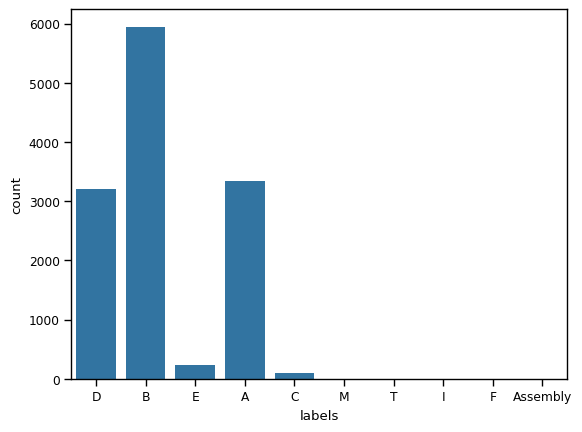

In [ ]:
sns.countplot(df, x='labels')

Text(0.5, 1.0, 'meta-llama/Llama-2-7b-chat-hf 0-shot')

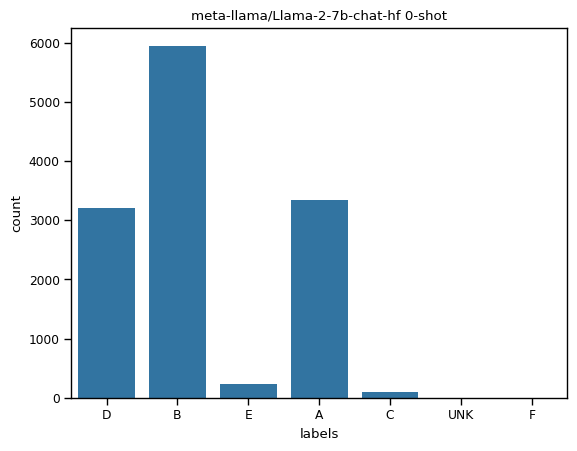

In [ ]:
accepted = ['A', 'B', 'C', 'D', 'E','F']
filtered = df.map(lambda val: val if val in accepted else 'UNK')
sns.countplot(filtered, x='labels', ).set_title(f"{model_name} 0-shot")

In [ ]:
import pickle
pickle.dump(responses, open(f"{model_name[model_name.index('/')+1:]}_{n_examples}responses_full.pk", "wb"))

In [ ]:
# log results
with open(f"{n_examples}_shot_full.txt", "a") as file:
    file.write(f"{model_name} : {num_correct}/{len(full_liar)-len(entries)}\n")

In [ ]:
# print results up till now
with open(f"{n_examples}_shot_full.txt", "r") as file:
    print(file.read())

meta-llama/Llama-2-7b-chat-hf : 2384/12836

